In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import datetime

In [5]:
data_raw = pd.read_csv('IVE_tickbidask.txt', header=None, names=['Date','Time','Price','Bid','Ask','Size'])

In [6]:
data = data_raw.iloc[:100000]

In [7]:
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data = data.drop(columns = ['Date', 'Time'])
data = data.set_index('DateTime')

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
from scipy import stats
from bars import *

In [10]:
bars = TickBarSeries(data)
tick_bars = bars.process_ticks(frequency = 100)
print tick_bars.head()

                     close   high    low   open  volume
DateTime                                               
2009-09-28 09:47:22  51.06  51.07  50.71  50.79   30044
2009-09-28 09:54:38  51.13  51.15  51.06  51.06   28975
2009-09-28 10:00:15  51.21  51.21  51.08  51.13   32841
2009-09-28 10:05:50  51.21  51.28  51.20  51.21   33764
2009-09-28 10:15:13  51.25  51.29  51.19  51.22   37104


In [11]:
from statsmodels.tsa.stattools import adfuller

In [12]:
def getWeights(d,size):
    w=[1.]
    for k in range(1,size):
        w_=-w[-1]/k*(d-k+1)
        w.append(w_)
    w=np.array(w[::-1]).reshape(-1,1)
    return w

def fracDiff(series,d,thres=.001):

    #1) Compute weights for the longest series
    w=getWeights(d,series.shape[0])
    #2) Determine initial calcs to be skipped based on weight-loss threshold
    w_=np.cumsum(abs(w))
    w_/=w_[-1]
    skip=w_[w_>thres].shape[0]
    #3) Apply weights to values
    df={}
    for name in series.columns:
        seriesF,df_=series[[name]].fillna(method='ffill').dropna(),pd.Series()
        for iloc in range(skip,seriesF.shape[0]):
            loc=seriesF.index[iloc]
            if not np.isfinite(series.loc[loc,name]):continue # exclude NAs
            df_[loc]=np.dot(w[-(iloc+1):,:].T,seriesF.loc[:loc])[0,0]
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df


# Differentiation for tick bars

In [13]:
corrs, adfs = [], []

for d in np.arange(0.0, 2.1, 0.1):
    ts1 = np.log(tick_bars)
    ts2 = fracDiff(ts1, d)

    corr = np.corrcoef(ts1.loc[ts2.index,'close'],ts2['close'])[0,1]
    adf = adfuller(ts2.close)[0]

    corrs.append(corr)
    adfs.append(adf)

KeyboardInterrupt: 

In [ ]:
stats = pd.DataFrame({
    'd': np.arange(0.0, 2.1, 0.1),
    'corr': corrs,
    'adfs': adfs
})
stats.index = stats['d']

In [ ]:
stats[['corr', 'adfs']].plot(secondary_y='adfs')
plt.show()

In [335]:
adfuller(tick_bars.close.diff().fillna(1e-5))[0]

-18.301437043431015

# Exercises

In [157]:
gauss = np.random.normal(0, 1, 1000)

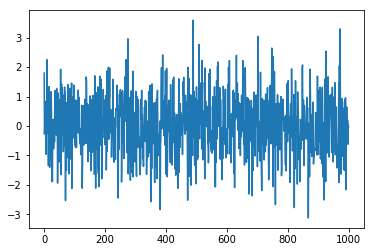

In [158]:
plt.figure()
plt.plot(gauss)
plt.show()

In [159]:
adfuller(gauss)

(-30.721619887470883,
 0.0,
 0,
 999,
 {'1%': -3.4369127451400474,
  '10%': -2.568312754566378,
  '5%': -2.864437475834273},
 2766.951680753896)

In [161]:
adfuller(np.cumsum(gauss))

(-1.6300726870515139,
 0.4674526661720234,
 0,
 999,
 {'1%': -3.4369127451400474,
  '10%': -2.568312754566378,
  '5%': -2.864437475834273},
 2765.4906005929283)

In [164]:
adfuller(np.diff(np.diff(np.cumsum(gauss))))

(-14.66133248162864,
 3.377743248351254e-27,
 14,
 983,
 {'1%': -3.4370198458812156,
  '10%': -2.568337912084273,
  '5%': -2.864484708707697},
 2829.3679503081694)